## In this file, I create holdback set with single posts.
## Resources
[NLTK][https://stackabuse.com/text-classification-with-python-and-scikit-learn/]

In [8]:
import nltk
import pickle
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import accuracy_score, precision_score, classification_report, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# nltk.download('stopwords')
# nltk.download('wordnet')

In [9]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [10]:
train_size = 0.8
vectorizer_max_features = 1500
chosen_classifier = MultinomialNB

In [11]:
from functions import load_data_set, sanitize_posts
myers_briggs = load_data_set()

In [12]:
mb_df = pd.DataFrame(myers_briggs, columns=['type', 'posts'])
types = sorted(mb_df['type'].unique())

post_list = [re.split('\|\|\|+', post) for post in mb_df['posts']]
post_df = pd.DataFrame(post_list)
post_df.insert(loc=0, column='type', value=mb_df['type'])

posts_by_type = {typ: mb_df[mb_df['type'] == typ] for typ in types}

In [13]:
vertical_post_df = pd.read_csv('vertical_posts.csv', index_col=0)

In [14]:
# For Over/Under samplling
X_nat, y_nat = mb_df['posts'], mb_df['type']
RandomUnderSampler()
rus = RandomUnderSampler({'INFJ': 700, 'INFP': 700, 'INTJ': 700, 'INTP': 700})
X, y = rus.fit_sample(pd.DataFrame(X_nat), y_nat)
X_train_val, X_holdback, y_train_val, y_holdback = train_test_split(X, y)
documents = sanitize_posts(X_train_val['posts'])

# For the original set
X, y = mb_df['posts'], mb_df['type']
# X, y = vertical_post_df['posts'], vertical_post_df['type']
X_train_val, X_holdback, y_train_val, y_holdback = train_test_split(X, y)
documents = sanitize_posts(X_train_val)

## Might want to remove URLs

In [19]:
vectorizer = CountVectorizer(max_features=vectorizer_max_features, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(X_train_val['posts']).toarray()

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y_train_val, train_size=train_size, random_state=0)

In [22]:
# classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier = chosen_classifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 0 13  0  2  0  0  0  0 11  4  1  0  0  0  0  0]
 [ 0 71  0  7  0  0  0  0  6 12 10  0  0  0  0  1]
 [ 0  3  1 10  0  0  0  0  2  3 15  1  0  0  0  0]
 [ 0 10  0 74  0  0  0  0  7  4  9  8  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  1  2  0  2  0  0  0  0]
 [ 0  1  0  3  0  0  0  0  0  0  2  2  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  1  2  2  0  0  0  0  0]
 [ 0  2  0  4  0  0  0  0  1  1  2  0  0  0  0  0]
 [ 0  9  0  4  0  0  0  0 56 27  5  1  0  0  0  0]
 [ 0 11  0  5  0  0  0  0  9 67  6  4  0  1  0  0]
 [ 0  1  0 10  0  0  0  0 13  9 53  8  0  0  0  0]
 [ 0  6  0 11  0  0  0  0 10 19 18 49  0  0  0  0]
 [ 0  7  0  3  0  0  0  0 11  6  1  0  0  0  0  0]
 [ 0  9  0  6  0  0  0  0  3 15  1  0  0  0  0  0]
 [ 0  5  0  3  0  0  0  0  3  8  6  0  0  0  0  0]
 [ 0  7  0  7  0  0  0  0  8  8  9  6  0  0  0  7]]
              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        31
        ENFP       0.46      0.66      0.54       107
        ENTJ       1

In [24]:
with open('text_classifier', 'wb') as picklefile:
    pickle.dump(classifier,picklefile)

In [25]:
with open('text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

In [26]:
y_pred2 = model.predict(X_test)

print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))
print(accuracy_score(y_test, y_pred2)) 

[[ 0 13  0  2  0  0  0  0 11  4  1  0  0  0  0  0]
 [ 0 71  0  7  0  0  0  0  6 12 10  0  0  0  0  1]
 [ 0  3  1 10  0  0  0  0  2  3 15  1  0  0  0  0]
 [ 0 10  0 74  0  0  0  0  7  4  9  8  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  1  2  0  2  0  0  0  0]
 [ 0  1  0  3  0  0  0  0  0  0  2  2  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  1  2  2  0  0  0  0  0]
 [ 0  2  0  4  0  0  0  0  1  1  2  0  0  0  0  0]
 [ 0  9  0  4  0  0  0  0 56 27  5  1  0  0  0  0]
 [ 0 11  0  5  0  0  0  0  9 67  6  4  0  1  0  0]
 [ 0  1  0 10  0  0  0  0 13  9 53  8  0  0  0  0]
 [ 0  6  0 11  0  0  0  0 10 19 18 49  0  0  0  0]
 [ 0  7  0  3  0  0  0  0 11  6  1  0  0  0  0  0]
 [ 0  9  0  6  0  0  0  0  3 15  1  0  0  0  0  0]
 [ 0  5  0  3  0  0  0  0  3  8  6  0  0  0  0  0]
 [ 0  7  0  7  0  0  0  0  8  8  9  6  0  0  0  7]]
              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        31
        ENFP       0.46      0.66      0.54       107
        ENTJ       1

In [27]:
print(chosen_classifier, vectorizer_max_features, train_size)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Precision:", precision_score(y_test, y_pred2, average='micro'))
print("Precision:", precision_score(y_test, y_pred2, average=None))
cr = classification_report(y_test, y_pred2)
cr.split('\n')

<class 'sklearn.naive_bayes.MultinomialNB'> 1500 0.8
Accuracy: 0.4359861591695502
Precision: 0.4359861591695502
Precision: [0.         0.45512821 1.         0.49006623 0.         0.
 0.         0.         0.3943662  0.35828877 0.37857143 0.60493827
 0.         0.         0.         0.875     ]


['              precision    recall  f1-score   support',
 '',
 '        ENFJ       0.00      0.00      0.00        31',
 '        ENFP       0.46      0.66      0.54       107',
 '        ENTJ       1.00      0.03      0.06        35',
 '        ENTP       0.49      0.66      0.56       112',
 '        ESFJ       0.00      0.00      0.00         7',
 '        ESFP       0.00      0.00      0.00         8',
 '        ESTJ       0.00      0.00      0.00         6',
 '        ESTP       0.00      0.00      0.00        10',
 '        INFJ       0.39      0.55      0.46       102',
 '        INFP       0.36      0.65      0.46       103',
 '        INTJ       0.38      0.56      0.45        94',
 '        INTP       0.60      0.43      0.51       113',
 '        ISFJ       0.00      0.00      0.00        28',
 '        ISFP       0.00      0.00      0.00        34',
 '        ISTJ       0.00      0.00      0.00        25',
 '        ISTP       0.88      0.13      0.23        52',
 '',
 '  

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1], pos_label='I')

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for E-I');
print("ROC AUC score = ", roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1]))

ValueError: multi_class must be in ('ovo', 'ovr')

## Run model on verticalized holdbacks

In [33]:
holdback_df = pd.DataFrame(zip(y_holdback, X_holdback['posts']), columns=('type', 'posts'))

In [34]:
holdback_post_list = [re.split('\|\|\|+', post) for post in holdback_df['posts']]
holdback_post_df = pd.DataFrame(holdback_post_list)
holdback_post_df.insert(loc=0, column='type', value=holdback_df['type'])

In [35]:
# Splits posts of holdback set into single posts.
def compress_posts(df):
    result = []
    df_length = range(len(df))

    for i in df_length:
        for j in range(58):
            if df.iloc[i][j] != None:
                result.append([df['type'][i], df.iloc[i][j]])
    
    return pd.DataFrame(result, columns=('type', 'post'))

vertical_holdback = compress_posts(holdback_post_df)

In [36]:
# sanitize and vectorize
documents = sanitize_posts(vertical_holdback['post'])

In [37]:
vertical_X_holdback = vectorizer.transform(documents).toarray()
vertical_X_holdback = tfidfconverter.fit_transform(vertical_X_holdback).toarray()
pred_holdback = classifier.predict(vertical_X_holdback)

In [38]:
print(chosen_classifier, vectorizer_max_features, train_size)

print("Accuracy:", accuracy_score(vertical_holdback['type'], pred_holdback))
print("Precision:", precision_score(vertical_holdback['type'], pred_holdback, average='micro'))
print("Precision:", precision_score(vertical_holdback['type'], pred_holdback, average=None))
cr = classification_report(vertical_holdback['type'], pred_holdback)
cr.split('\n')

<class 'sklearn.naive_bayes.MultinomialNB'> 1500 0.8
Accuracy: 0.18802555383236344
Precision: 0.18802555383236344
Precision: [0.23529412 0.18259345 0.4137931  0.20887728 0.         0.
 0.         0.         0.1755921  0.19265571 0.16175827 0.28746692
 0.4375     0.34444444 0.28       0.37234043]


['              precision    recall  f1-score   support',
 '',
 '        ENFJ       0.24      0.00      0.00      2324',
 '        ENFP       0.18      0.30      0.23      7531',
 '        ENTJ       0.41      0.00      0.01      2947',
 '        ENTP       0.21      0.22      0.21      8075',
 '        ESFJ       0.00      0.00      0.00       413',
 '        ESFP       0.00      0.00      0.00       472',
 '        ESTJ       0.00      0.00      0.00       350',
 '        ESTP       0.00      0.00      0.00      1237',
 '        INFJ       0.18      0.28      0.22      8304',
 '        INFP       0.19      0.29      0.23      8852',
 '        INTJ       0.16      0.37      0.22      8080',
 '        INTP       0.29      0.12      0.17      9856',
 '        ISFJ       0.44      0.00      0.01      2456',
 '        ISFP       0.34      0.01      0.02      3759',
 '        ISTJ       0.28      0.00      0.01      2220',
 '        ISTP       0.37      0.02      0.04      3407',
 '',
 '  

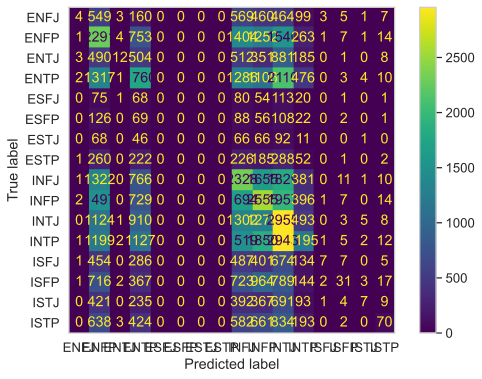

In [39]:
plot_confusion_matrix(classifier, vertical_X_holdback, vertical_holdback['type'])
plt.grid(False)
plt.show()

In [40]:
classifier.predict_proba(vertical_X_holdback)

array([[0.01985084, 0.12981715, 0.02611568, ..., 0.03124424, 0.02423118,
        0.04088717],
       [0.03113375, 0.12688403, 0.02829927, ..., 0.04907606, 0.03173377,
        0.05547589],
       [0.03063299, 0.15582873, 0.0292043 , ..., 0.04551823, 0.02497454,
        0.04817048],
       ...,
       [0.02809491, 0.13046416, 0.03398685, ..., 0.04034728, 0.03088997,
        0.06782329],
       [0.03462083, 0.09857904, 0.04482811, ..., 0.05397893, 0.06622799,
        0.08023877],
       [0.02531618, 0.13874896, 0.03074216, ..., 0.03324631, 0.03278015,
        0.06167427]])

In [41]:
fpr, tpr, thresholds = roc_curve(vertical_holdback['type'], classifier.predict_proba(vertical_X_holdback)[:,1], pos_label='I')

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for E-I');
print("ROC AUC score = ", roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1]))

ValueError: multi_class must be in ('ovo', 'ovr')

In [ ]:
from collections import Counter

personality_count = Counter()

for i in mb_df['type']:
    personality_count[i] += 1

personality_types = sorted(personality_count)
post_count = [personality_count[x] for x in personality_types]

In [ ]:
plt.bar(personality_types, post_count)
plt.xticks(rotation=90)
plt.xlabel('Personality Type')
plt.ylabel('Number of Posts')

In [42]:
albert = "Hi, everyone!  I’m a San Francisco native who attended Caltech in Pasadena and has spent time all over the country.  My favorite cities are San Francisco, Boston, Raleigh, and Denver.  I am a bootcamp veteran, having acquired a skill set in web development, and where I, amazingly, met Josh Shaman who now works for Metis.  I bike, play piano, and dance in my spare time."

trans_albert = vectorizer.transform([albert]).toarray()
trans_albert = tfidfconverter.fit_transform(trans_albert).toarray()
classifier.predict(trans_albert)

array(['INFP'], dtype='<U4')